### Quantum Gate calibration using Model Free Reinforcement Learning in AWS Backend

In [1]:
from qiskit_braket_provider import BraketLocalBackend, AWSBraketProvider, AWSBraketBackend, AWSBraketJob
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import boto3
client = boto3.client("braket", region_name='us-west-1')
import braket._sdk as braket_sdk
braket_sdk.__version__

# %%
# response = client.search_devices(filters=[{
#     'name': 'deviceArn',
#     'values': ['arn:aws:braket:::device/quantum-simulator/amazon/sv1']
# }], maxResults=10)
# print(f"Found {len(response['devices'])} devices")

# response = client.get_device(deviceArn='arn:aws:braket:::device/quantum-simulator/amazon/sv1')
# print(f"Device {response['deviceName']} is {response['deviceStatus']}")

# %%
import numpy as np
import os
import sys
from typing import Optional
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from helper_functions import select_optimizer, generate_model
from qconfig import QiskitConfig
from template_configurations import gate_q_env_config
from agent import Agent
from helper_functions import load_agent_from_yaml_file
from ppo import make_train_ppo
from qconfig import QEnvConfig

# Qiskit imports for building RL environment (circuit level)
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.providers import BackendV2
from qiskit.providers.fake_provider import FakeJakarta, FakeJakartaV2
from qiskit.extensions import CXGate, XGate
from qiskit.opflow import Zero, One, Plus, Minus, H, I, X, CX, S, Z
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(
I0000 00:00:1704437779.958901       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'rz', 'delay', 'sdg', 'measure', 'x', 'reset', 'tdg', 't', 'z', 's', 'h', 'id'}
  q1: {'sx', 'rz', 'delay', 'sdg', 'measure', 'x', 'reset', 'tdg', 't', 'z', 's', 'h', 'id'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'cr45m', 'ecr'}
  (1, 0): {'cr45p', 'cr45m', 'ecr'}
)>


In [2]:
# backend_name = 'ibm_perth'
# no_backend = None
# backend = no_backend

In [3]:
# %%
provider = AWSBraketProvider()
backend = provider.get_backend('SV1')

# backend = BraketLocalBackend()    
# backend = LocalSimulator()

In [4]:
print('Type of the backend', type(backend))
print(isinstance(backend, (AWSBraketBackend, LocalSimulator, BraketLocalBackend)))

Type of the backend <class 'qiskit_braket_provider.providers.braket_backend.AWSBraketBackend'>
True


In [5]:
q_env = QuantumEnvironment(gate_q_env_config)
print("Backend:", q_env.backend)

ppo_params, network_params  = load_agent_from_yaml_file(file_path='/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')
agent_config = {**ppo_params, **network_params}

SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])
Backend: BraketBackend[SV1]


In [6]:
total_updates = 200

In [7]:
ppo_agent = make_train_ppo(agent_config, q_env)
training_results = ppo_agent(total_updates=total_updates, print_debug=True, num_prints=40)

100%|██████████| 200/200 [00:41<00:00,  4.80it/s]


Fidelity History: []


#### Plot Training History

In [8]:
gate_name = gate_q_env_config.target["gate"].name

Text(0, 0.5, 'Avg. Return')

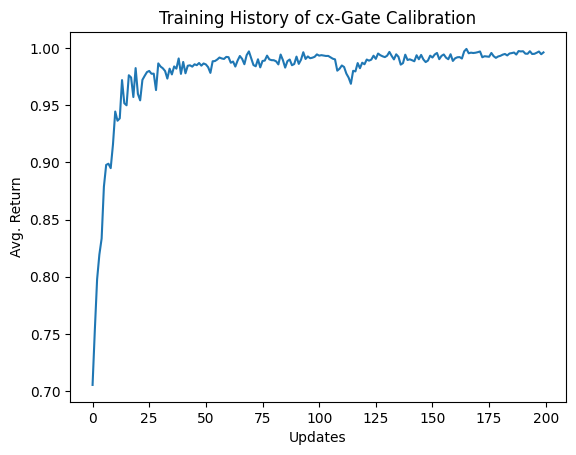

In [9]:
fig, ax = plt.subplots()
plt.plot(training_results['avg_return'])
ax.set_title(f'Training History of {gate_name}-Gate Calibration')
ax.set_xlabel('Updates')
ax.set_ylabel('Avg. Return')